In [1]:
# silly autoreload to avoid restarting the kernel every time
%load_ext autoreload
%autoreload 2

import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import solve_ivp
from ekf_vindy.plotting import plotter
from ekf_vindy.utils import add_noise_with_snr
from ekf_vindy.filters.config import DynamicsConfig
from ekf_vindy.filters.ekf import EKF
from scipy.integrate import odeint

seed = 29
np.random.seed(seed)

/home/carlos/.cache/pypoetry/virtualenvs/vindy-MoRRIXoN-py3.11/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


LaTeX is installed. Using LaTeX for rendering.


Let's consider a dynamical system where we have an invariant (constraint) that does **not** depend on the time-varying parameters of the system, but only on the state. The toy example is *Lotka-Volterra* system with a fixed total population, but where the rate at which the individual populations change varies over time (one degree of freedom).

Assume the population must always be $N=100$, and it evolves like so

$$
\begin{aligned}
\dot{x} &= x(a(t)y - b(t)x),\\
\dot{y} &= y(b(t)x- a(t)y).
\end{aligned}
$$


And we ask that, whatever the system does, we have $x + y = N$. This implies $y = N - x$. We can reparametrize with $u = {x}/{N}$, and $v=1-u$. So we obtain the ODE

$$
\dot{u} = Nu\Big((a(t)-b(t)) - (a(t)+b(t))u\Big)
$$

Let's generate data with some sinusoidal $a(t)$ and $b(t)$

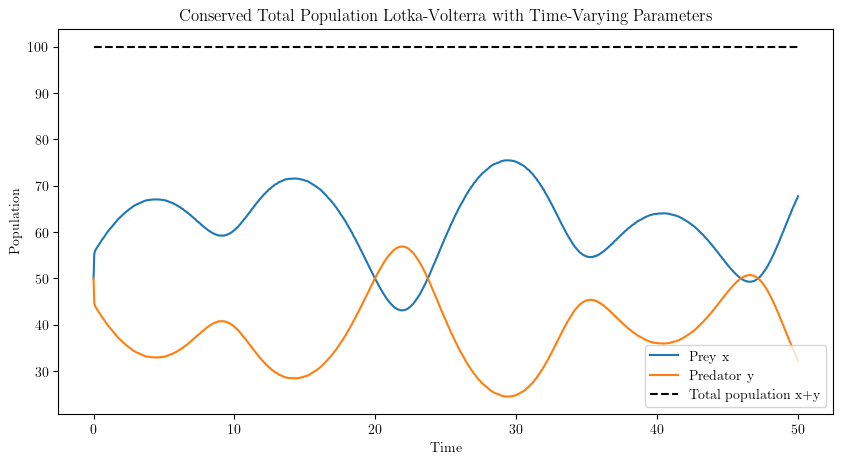

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Total population
N = 100

# Time-varying parameters
def a(t):
    return 0.5 + 0.2*np.sin(0.5*t)  # prey benefit from interaction

def b(t):
    return 0.3 + 0.1*np.cos(0.3*t)  # prey competition effect

# ODE for prey x
def dxdt(t, x):
    y = N - x
    return x*(a(t)*y - b(t)*x)

# Initial condition
x0 = 50  # Half of total population

# Solve ODE
t_span = (0, 50)
t_eval = np.linspace(*t_span, 1000)
sol = solve_ivp(dxdt, t_span, [x0], t_eval=t_eval, vectorized=True)

# Compute predator y
x = sol.y[0]
y = N - x

# Plot
plt.figure(figsize=(10,5))
plt.plot(sol.t, x, label='Prey x')
plt.plot(sol.t, y, label='Predator y')
plt.plot(sol.t, x+y, 'k--', label='Total population x+y')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Conserved Total Population Lotka-Volterra with Time-Varying Parameters')
plt.legend()
plt.show()